In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [40]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/[23-1]_DSL세션/[0207]_Dimensionality Reduction_실습, 과제/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [41]:
from sklearn.model_selection import train_test_split

# 60000개 데이터 중 10000개만 사용
fashion = fashion.loc[:9999,:] 

# 레이블 제외한 나머지 변수들 데이터프레임으로 만들기
data = fashion.iloc[:,1:]

# 정답 레이블은 따로 데이터프레임으로 만들어놓기 
label = fashion['label'] 

# train_test_split
# stratify=label로 라벨 분포 조정
# train 데이터 8000개, test 데이터 2000개 사용용
X_train, X_test, y_train, y_test = train_test_split(data, label, train_size=0.8, test_size=0.2, random_state = 42, stratify=label) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 784) (2000, 784) (8000,) (2000,)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


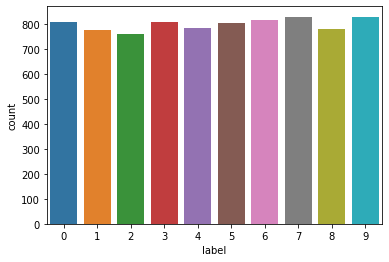

In [42]:
#train dataset 시각화
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


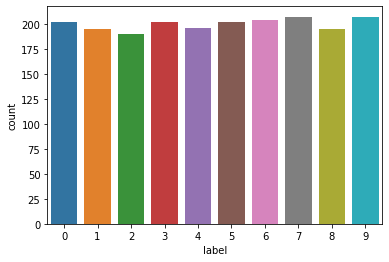

In [43]:
#test dataset 시각화
sns.countplot(y_test) #y라벨이 균등하게 분포하는지 확인
plt.show()

In [37]:
y_train.loc[4]

KeyError: ignored

- 어떻게 생긴 데이터셋인지 확인해보기

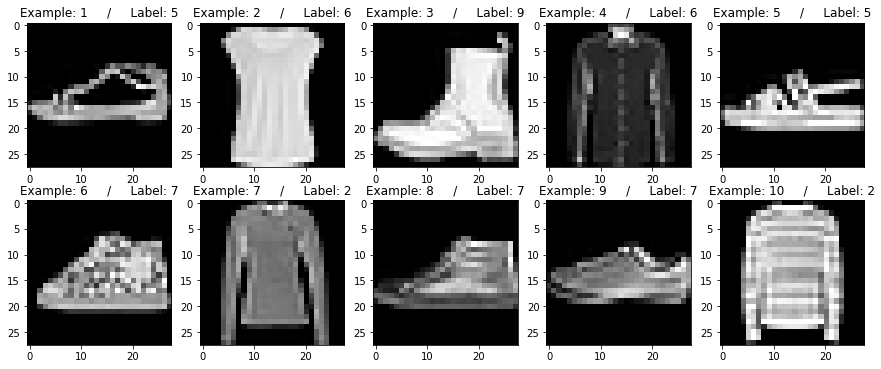

In [44]:
# loc가 아니라 iloc로 하니까 에러가 안 뜨네...!
# y_train.loc[4]는 에러 발생

plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.iloc[i]
  image = X_train.iloc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=784) #784차원의 잠재변수 처음에는 784차원 그대로 설정
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA.shape

(8000, 784)

In [47]:
pca.explained_variance_ratio_[:10]

array([0.29117931, 0.17433379, 0.06117723, 0.05089129, 0.03820518,
       0.03469072, 0.02304865, 0.01969151, 0.01337907, 0.01322438])

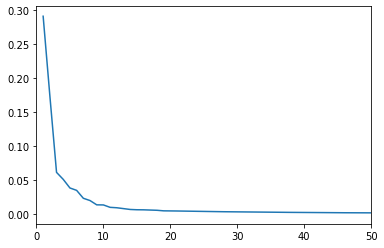

In [49]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

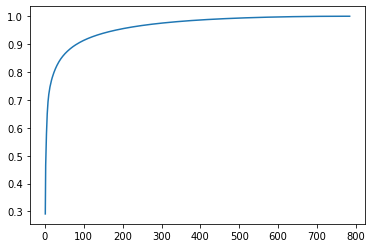

In [50]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [51]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.98%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.51%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.33%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.36%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [52]:
cumulative=np.array(cumulative)
np.where(cumulative>0.9)[0][0] #81개 쓰면 분산의 90%이상을 설명

# 90%의 분산을 설명하면 충분하다고 판단 -> 81개의 잠재 변수 사용

81

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [53]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=81) # 81개의 잠재 변수
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (8000, 784)
After PCA: (8000, 81)


### 1. Logistic regression

In [54]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train accuracy: 1.0
test accuracy: 0.771
105.2111sec


In [55]:
#차원축소 이후(81차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.865125
test accuracy: 0.8435
30.8061sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-Logistic regression 결과 해석

*   overfitting이 심하게 나타난 현상이 차원 축소 이후 개선된 모습을 보임
*   test accuracy도 차원 축소 이후가 더 좋은 성능을 보여 차원 축소가 효과적이었다고 해석할 수 있음



### 2. Random Forest

In [56]:
#차원축소 이전(784차원)
start = time.time()
rf_original = RandomForestClassifier()
rf_original.fit(X_train, y_train)
print('train accuracy:', accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:', accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8615
19.9406sec


In [57]:
#차원축소 이후(81차원)
start = time.time()
rf_original = RandomForestClassifier()
rf_original.fit(X_train_PCA, y_train)
print('train accuracy:', accuracy_score(y_train, rf_original.predict(X_train_PCA)))
print('test accuracy:', accuracy_score(y_test, rf_original.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8475
12.6304sec


-Random Forest 결과 해석

*   학습 속도가 약간 감소함
*   성능은 크게 개선되지 않았음. rf의 경우 decision tree를 병렬적으로 여러 개 사용하면서 DT가 야기할 수 있는 과적합 문제를 이미 어느정도 해결한 것으로 보임



### 3. XGBoost

In [58]:
#차원축소 이전(784차원)
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.935
test accuracy: 0.8645
217.2147sec


In [59]:
#차원축소 이후(81차원)
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.912125
test accuracy: 0.84
66.4484sec


-XGBoost 결과 해석

*   학습 속도 감소 1/3 수준
*   성능은 조금 낮아졌으나 괜찮은 편인 것 같다다



# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

## PCA
- 분산을 크게하는 잠재변수를 찾자

In [60]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

1.4608sec


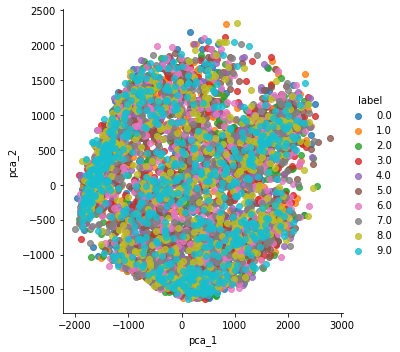

In [61]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

## LDA
- class(label)을 잘 구분해주는 축을 찾자

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.4693sec


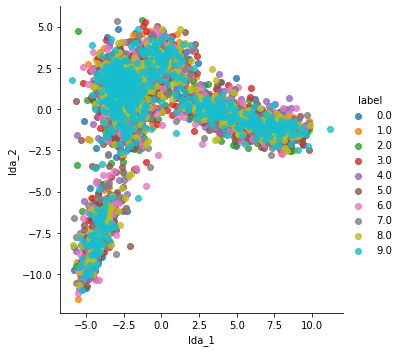

In [63]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

## KPCA
- 고차원에서 분산을 크게 해주는 축을 찾자
- 데이터의 형태에 따라 적절한 커널 및 하이퍼파라미터을 사용해줄 필요 있음.

In [64]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

38.8329sec


In [65]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

50.0955sec


In [78]:
start=time.time()
linear_pca = KernelPCA(n_components = 2, kernel="linear", gamma=0.001, coef0=1, fit_inverse_transform=True) #선형 커널 사용
X_train_linear_pca=linear_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec') 

41.4279sec


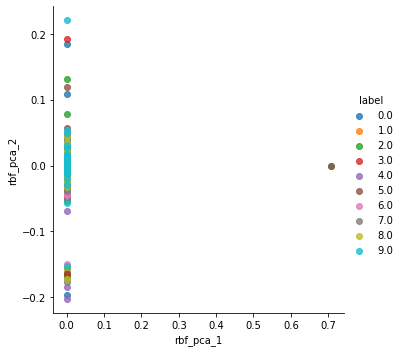

In [68]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

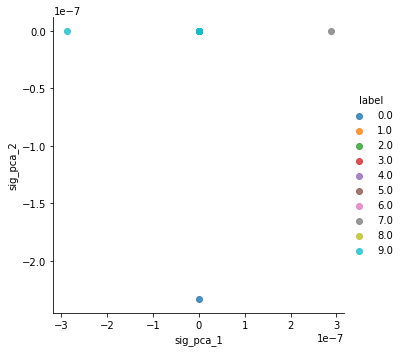

In [69]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

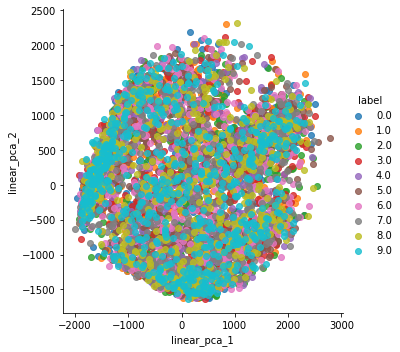

In [79]:
X_train_linear_pca=pd.DataFrame(X_train_linear_pca).loc[:,0:1]
X_train_linear_pca=pd.concat((X_train_linear_pca, y_train), axis=1) 
X_train_linear_pca.columns=['linear_pca_1', 'linear_pca_2', 'label']

sns.lmplot(x='linear_pca_1',y='linear_pca_2',data=X_train_linear_pca,hue='label',fit_reg=False)
plt.show()

## ISOMAP
- 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자

In [71]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4) # 이웃한 애들에만 엣지를 그어서 거리를 계산, 이에 대한 하이퍼파라미터 : 이웃 5명
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

65.5671sec


In [72]:
from sklearn.manifold import Isomap
start=time.time()
isomap2=Isomap(n_neighbors=10,n_components=2,n_jobs=4) # 이웃한 애들에만 엣지를 그어서 거리를 계산, 이에 대한 하이퍼파라미터 : 이웃 10명 
X_train_isomap2=isomap2.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

72.6680sec


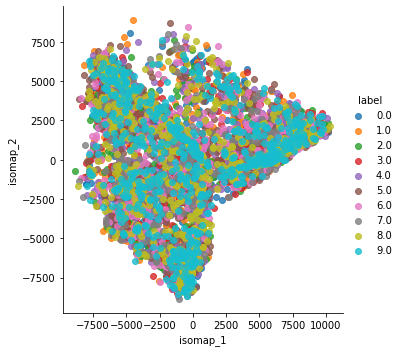

In [73]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

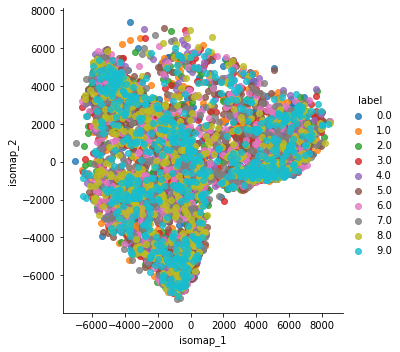

In [74]:
X_train_isomap2=pd.DataFrame(X_train_isomap2).loc[:,0:1]
X_train_isomap2=pd.concat((X_train_isomap2, y_train), axis=1) 
X_train_isomap2.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap2,hue='label',fit_reg=False)
plt.show()

## t-SNE
- 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자

In [75]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


89.3137sec


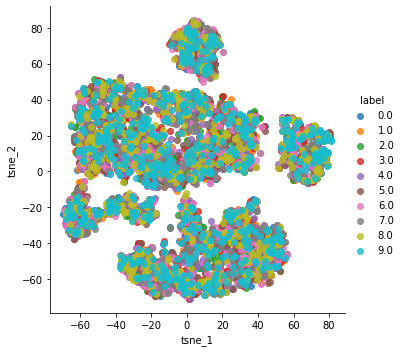

In [76]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 t-SNE다다

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

전반적으로 Label 9에 대한 분류가 제대로 되지 않은 것 같다
그 이유로는 Label 9가 Label 5,7과는 모습이 비슷하고, 하얀색 픽셀이 차지하는 면적이 넓어 Label 6과도 비슷하게 분류가 될 수 있었을 것 같다.  

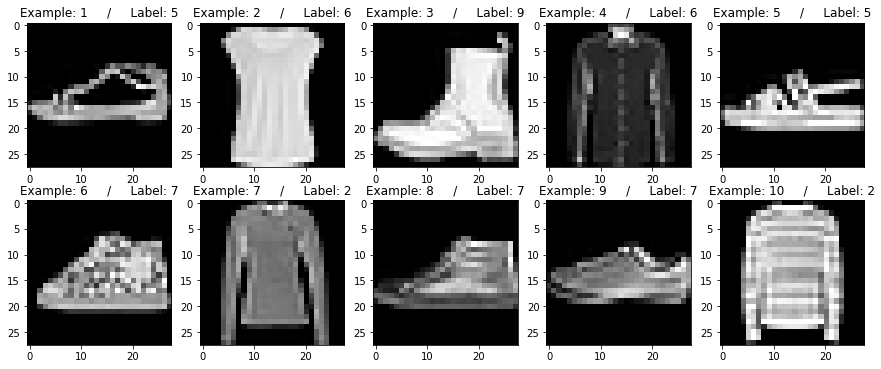

In [80]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.iloc[i]
  image = X_train.iloc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

수고하셨습니다~